
# Faster R-CNN Implementation

### Dataset format for Faster-RCNN code  :    (fname_path, xmin, xmax, ymin, ymax, class_name)


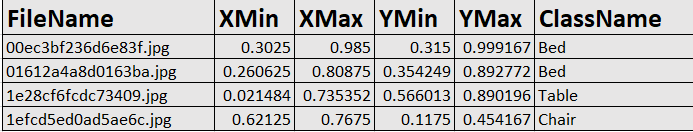

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
import wget
#url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
#filename = wget.download(url)

In [3]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
#filename = wget.download(url)

In [4]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
#filename = wget.download(url)

In [5]:
images_boxable_file = 'train-images-boxable-with-rotation.csv'
annotations_bbox_file = 'train-annotations-bbox.csv'
class_descriptions_file = 'class-descriptions-boxable.csv'

In [6]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [7]:
annotations_bbox = pd.read_csv(annotations_bbox_file)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [8]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [9]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Image: (552, 368, 3)
Coordinates: (0, 0), (367, 550)


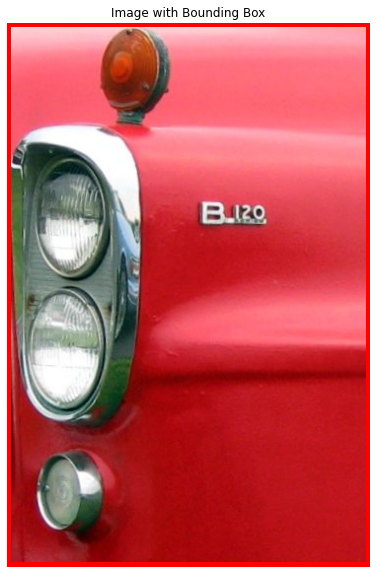

Image: (1194, 1200, 3)
Coordinates: (347, 153), (969, 1028)


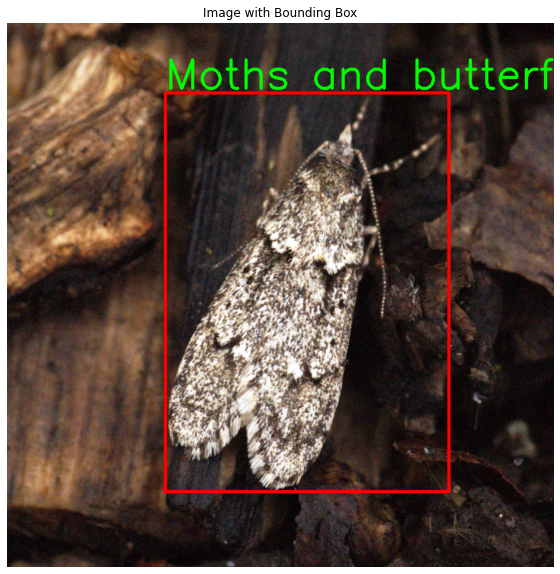

Image: (800, 1200, 3)
Coordinates: (51, 337), (482, 800)


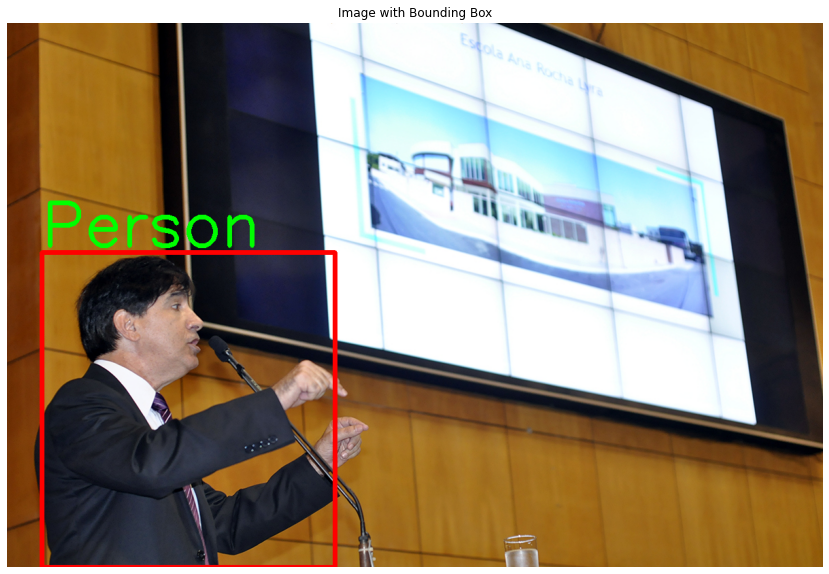

Image: (1200, 1600, 3)
Coordinates: (0, 0), (1599, 552)


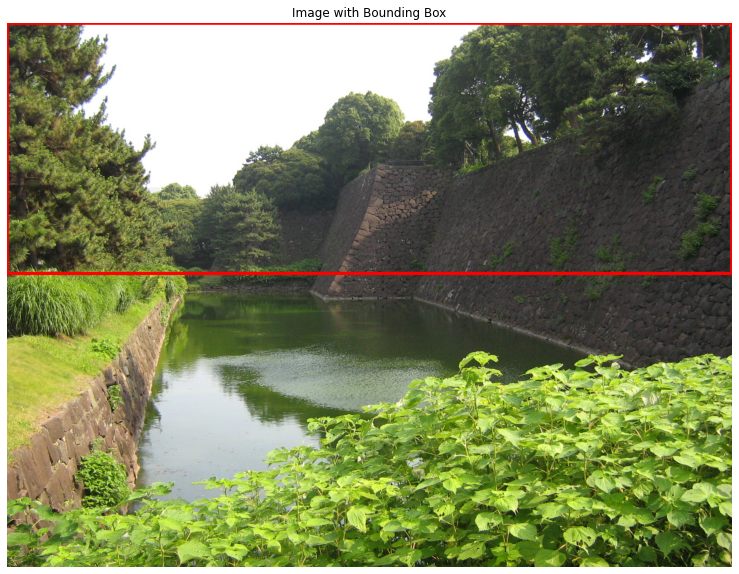

Image: (532, 800, 3)
Coordinates: (372, 158), (534, 341)


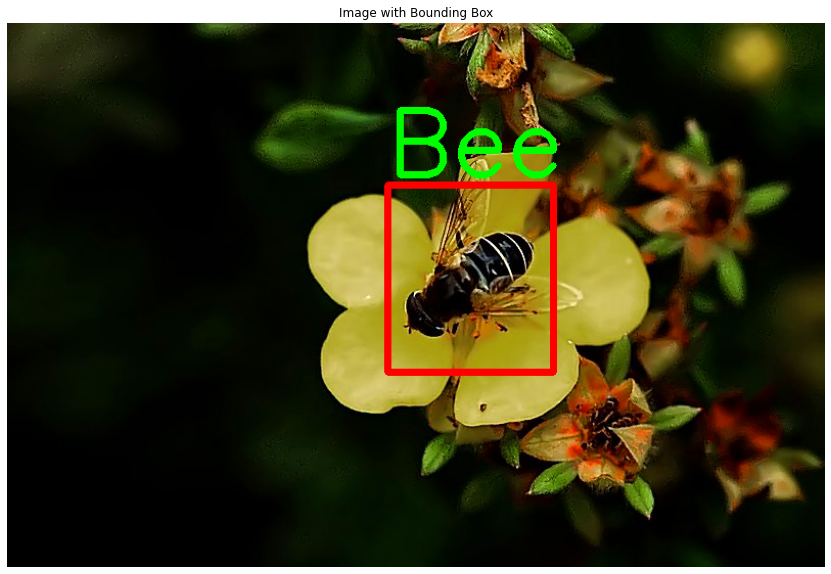

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

In [11]:
class_descriptions[1].count()

601

In [12]:
# Find the label_name for 'Bed', 'Chair' and 'Table' classes
bed_pd = class_descriptions[class_descriptions[1]=='Bed']
chair_pd = class_descriptions[class_descriptions[1]=='Chair']
table_pd = class_descriptions[class_descriptions[1]=='Table']

In [13]:
bed_pd

,0,1
257,/m/03ssj5,Bed


In [14]:
label_name_bed = bed_pd[0].values[0]
label_name_chair = chair_pd[0].values[0]
label_name_table = table_pd[0].values[0]

label_name_bed

'/m/03ssj5'

In [15]:
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bed]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_chair]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_table]

bed_bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
5953,00041cc3701f7805,xclick,/m/03ssj5,1,0.135112,0.366609,0.420573,0.625000,1,0,0,0,0
5954,00041cc3701f7805,xclick,/m/03ssj5,1,0.179862,0.405336,0.436198,0.856771,0,0,0,0,0
9974,00074503ceae5131,xclick,/m/03ssj5,1,0.000000,0.999375,0.000000,0.999062,1,1,0,0,0
13671,000a54f1bdb96839,xclick,/m/03ssj5,1,0.000000,0.999167,0.028125,0.999375,0,1,0,0,0
17469,000da932ca7e68e4,xclick,/m/03ssj5,1,0.000000,0.753125,0.328330,0.993433,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585203,ff7f55b7f6794f63,xclick,/m/03ssj5,1,0.000000,0.999375,0.000000,0.997500,1,1,0,0,0
14595452,ffb716498f082103,xclick,/m/03ssj5,1,0.180000,0.998750,0.309568,0.998124,0,0,0,0,0
14600295,ffce182988b6b746,xclick,/m/03ssj5,1,0.000000,0.305625,0.707317,0.999062,0,1,0,0,0
14602507,ffd718211ba34626,activemil,/m/03ssj5,1,0.006250,0.207500,0.373333,0.805000,1,1,0,0,0


In [16]:
print('There are %d beds in the dataset' %(len(bed_bbox)))
print('There are %d chairs in the dataset' %(len(chair_bbox)))
print('There are %d tables in the dataset' %(len(table_bbox)))


There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [17]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']

In [18]:
# working on 10 images
n = 10
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)

In [19]:
subbed_pd = images_boxable.loc[images_boxable['ImageID'].isin(subbed_img_id)]
subchair_pd = images_boxable.loc[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtable_img_id)]

In [20]:
print("Beds:",subbed_pd.shape, "Chair:", subchair_pd.shape, "Tables:", subtable_pd.shape)

Beds: (10, 12) Chair: (10, 12) Tables: (10, 12)


In [21]:
subbed_pd.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
83201,549c014e85b4f826,train,https://farm7.staticflickr.com/5345/1777930479...,https://www.flickr.com/photos/tanty0/17779304791,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/tanty0/,Andrés Gómez García,15030003,776596,SDYMtOiWr+dPinpq8v1uXA==,https://c5.staticflickr.com/6/5345/17779304791...,0.0
186955,95223a6f064f0ebe,train,https://c7.staticflickr.com/1/79/409814110_842...,https://www.flickr.com/photos/daniello/409814110,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/daniello/,webmove,306 double room comic,35501,aeBBhtM5cxMaUy9tup/XLg==,NaN,NaN
626244,81cce43cfe337f48,train,https://c1.staticflickr.com/5/4043/4683561296_...,https://www.flickr.com/photos/heatheronhertrav...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/heatheronhertrav...,Heather Cowper,"Ionian Eco Villagers, Zakynthos",2748032,erPJs8BnlT9I7Bu5ulXi7Q==,https://c7.staticflickr.com/5/4043/4683561296_...,NaN
648503,1403567c4b4e1b25,train,https://farm6.staticflickr.com/28/41446693_3b0...,https://www.flickr.com/photos/raaphorst/41446693,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/raaphorst/,Marco Raaphorst,"Clarion hotel Stockholm, Sweden",357327,crQ/OSdhydGrBGF9WwvBFA==,https://c4.staticflickr.com/1/28/41446693_3b08...,NaN
660724,4d9b605cea2c1576,train,https://farm7.staticflickr.com/3896/1519807007...,https://www.flickr.com/photos/fotopavolfreso/1...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/fotopavolfreso/,Bratislavská župa,Za župné dotácie zrenovovali škôlky v seneckom...,659855,RyF4VRp039iY8Ml7vENLmg==,https://c8.staticflickr.com/4/3896/15198070072...,0.0


In [22]:
subbed_dict = subbed_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subchair_dict = subchair_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [23]:
mappings = [subbed_dict, subchair_dict, subtable_dict]

In [24]:

len(mappings)

3

In [25]:
len(mappings[0])

10

In [26]:
classes = ['Bed', 'Chair', 'Table']

In [27]:
# download images in folders(Bed, Chair and table folder with 10 images each)


for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 3
Images Issues: 0
Images Issues: 0


# Dataset format for Faster-RCNN code
## (fname_path, xmin, xmax, ymin, ymax, class_name)


In [28]:
# save images to train and test directory, so create 2 folders
train_path = 'train'
test_path = 'test'

In [29]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8) # 80% data for training and 20% for testing

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    

    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [30]:
train_img_count = os.listdir('D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/train')
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  52


In [31]:
test_img_count = os.listdir('D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/test')
print("Number of images in train found: ", len(test_img_count))

Number of images in train found:  66


In [32]:
label_names = [label_name_bed, label_name_chair, label_name_table]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [33]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,00ec3bf236d6e83f.jpg,0.302500,0.985000,0.315000,0.999167,Bed
1,01612a4a8d0163ba.jpg,0.260625,0.808750,0.354249,0.892772,Bed
2,0385cdfaf3d077f3.jpg,0.000625,0.150000,0.946667,0.998889,Chair
3,0385cdfaf3d077f3.jpg,0.041250,0.071875,0.523333,0.573333,Chair
4,0385cdfaf3d077f3.jpg,0.164375,0.173125,0.445556,0.508889,Chair


In [34]:
train_df.shape

(238, 6)

In [ ]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [36]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [37]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [38]:
#Write train.csv to annotation.txt

train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      train_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/train'
      fileName = os.path.join(train_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [39]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      test_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/test'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')